# Run Length Decoding 

In [127]:
import numpy as np
from pathlib import Path
import random
from PIL import Image as Img
import matplotlib.pyplot as plt
import pandas as pd
from skimage import color
from glob import glob
import os

### Configuration

In [70]:
ROOT_DIR = Path('\train')

In [71]:
df_train = pd.read_csv('train.csv')
df_train.head() 

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [72]:
df_train['class'].value_counts()

large_bowel    38496
small_bowel    38496
stomach        38496
Name: class, dtype: int64

In [73]:
list_images = glob('train/*/*/*/*.png')
list_images[0]

'train\\case101\\case101_day20\\scans\\slice_0001_266_266_1.50_1.50.png'

In [74]:
list_images[0].split("\\")

['train',
 'case101',
 'case101_day20',
 'scans',
 'slice_0001_266_266_1.50_1.50.png']

In [75]:
img_df = pd.DataFrame([ (item, item.split("\\")[2], item.split("\\")[-1]) for item  in list_images ],columns=['full_path', 'case_and_day', 'img_file_name'])
img_df.head()

,full_path,case_and_day,img_file_name
0,train\case101\case101_day20\scans\slice_0001_2...,case101_day20,slice_0001_266_266_1.50_1.50.png
1,train\case101\case101_day20\scans\slice_0002_2...,case101_day20,slice_0002_266_266_1.50_1.50.png
2,train\case101\case101_day20\scans\slice_0003_2...,case101_day20,slice_0003_266_266_1.50_1.50.png
3,train\case101\case101_day20\scans\slice_0004_2...,case101_day20,slice_0004_266_266_1.50_1.50.png
4,train\case101\case101_day20\scans\slice_0005_2...,case101_day20,slice_0005_266_266_1.50_1.50.png


In [76]:
img_df['slice'] = img_df['img_file_name'].apply(lambda x: f"slice_{x.split('_')[1]}")
img_df['height'] = img_df['img_file_name'].apply(lambda x: int(x.split("_")[2]))
img_df['width'] = img_df['img_file_name'].apply(lambda x: int(x.split("_")[3]))
img_df['id'] = img_df['case_and_day']+"_"+img_df['slice']

img_df.head()

,full_path,case_and_day,img_file_name,slice,height,width,id
0,train\case101\case101_day20\scans\slice_0001_2...,case101_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266,case101_day20_slice_0001
1,train\case101\case101_day20\scans\slice_0002_2...,case101_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266,case101_day20_slice_0002
2,train\case101\case101_day20\scans\slice_0003_2...,case101_day20,slice_0003_266_266_1.50_1.50.png,slice_0003,266,266,case101_day20_slice_0003
3,train\case101\case101_day20\scans\slice_0004_2...,case101_day20,slice_0004_266_266_1.50_1.50.png,slice_0004,266,266,case101_day20_slice_0004
4,train\case101\case101_day20\scans\slice_0005_2...,case101_day20,slice_0005_266_266_1.50_1.50.png,slice_0005,266,266,case101_day20_slice_0005


In [77]:
df_train = pd.merge(df_train, img_df, on='id', how='left')
df_train.head()

,id,class,segmentation,full_path,case_and_day,img_file_name,slice,height,width
0,case123_day20_slice_0001,large_bowel,NaN,train\case123\case123_day20\scans\slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
1,case123_day20_slice_0001,small_bowel,NaN,train\case123\case123_day20\scans\slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
2,case123_day20_slice_0001,stomach,NaN,train\case123\case123_day20\scans\slice_0001_2...,case123_day20,slice_0001_266_266_1.50_1.50.png,slice_0001,266,266
3,case123_day20_slice_0002,large_bowel,NaN,train\case123\case123_day20\scans\slice_0002_2...,case123_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266
4,case123_day20_slice_0002,small_bowel,NaN,train\case123\case123_day20\scans\slice_0002_2...,case123_day20,slice_0002_266_266_1.50_1.50.png,slice_0002,266,266


## Plot Images

In [88]:
list_images[0]

'train\\case101\\case101_day20\\scans\\slice_0001_266_266_1.50_1.50.png'

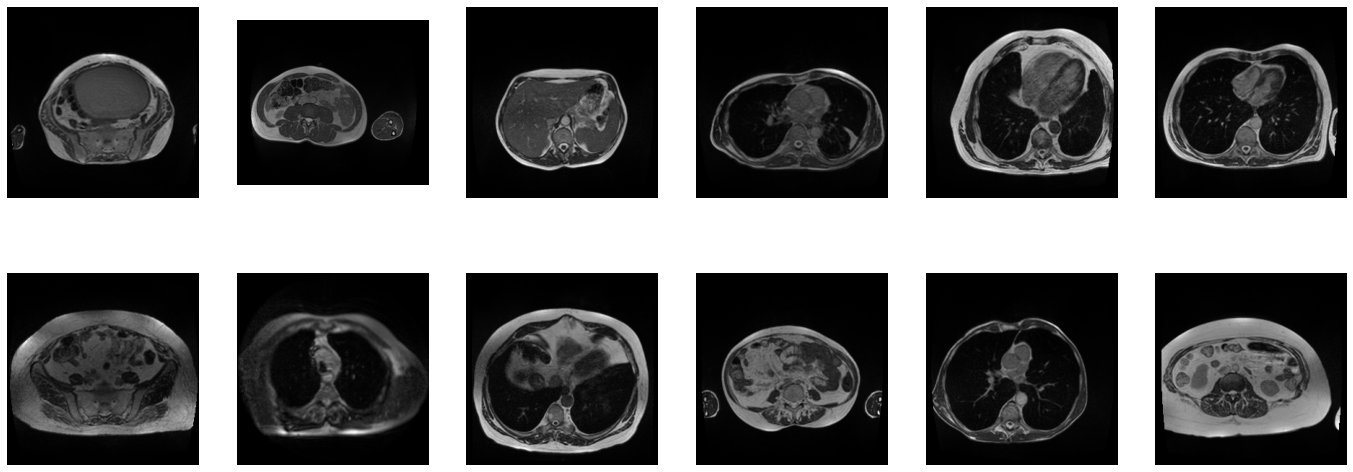

In [92]:
# list_images

num_rows, num_cols = 2, 6
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24,9))
images = random.choices(list_images, k=num_rows * num_cols)
for num, img in enumerate(images):
    i = num % num_cols
    j = num // num_cols
    image = Img.open(img)
    # image = image.convert("L")
    image = np.array(image)
    axes[j,i].axis('off')
    axes[j,i].imshow(image, cmap='gray')

# plt.subplots_adjust(wspace=0.05, hspace= 0.05)
plt.show()


In [93]:
def rle_decode(rle, height, width, fill = 255):
    s = rle.split()
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -= 1
    mask = np.zeros(height*width, dtype=np.int8)
    for position, run_length in zip(start, length):
        mask[position:position+run_length] = fill
    mask = mask.reshape(width, height).T
    mask = np.ascontiguousarray(mask)
    return mask

In [94]:
X = df_train[df_train['segmentation'].notnull()]
X.head()

,id,class,segmentation,full_path,case_and_day,img_file_name,slice,height,width
194,case123_day20_slice_0065,stomach,28094 3 28358 7 28623 9 28889 9 29155 9 29421 ...,train\case123\case123_day20\scans\slice_0065_2...,case123_day20,slice_0065_266_266_1.50_1.50.png,slice_0065,266,266
197,case123_day20_slice_0066,stomach,27561 8 27825 11 28090 13 28355 14 28620 15 28...,train\case123\case123_day20\scans\slice_0066_2...,case123_day20,slice_0066_266_266_1.50_1.50.png,slice_0066,266,266
200,case123_day20_slice_0067,stomach,15323 4 15587 8 15852 10 16117 11 16383 12 166...,train\case123\case123_day20\scans\slice_0067_2...,case123_day20,slice_0067_266_266_1.50_1.50.png,slice_0067,266,266
203,case123_day20_slice_0068,stomach,14792 5 15056 9 15321 11 15587 11 15852 13 161...,train\case123\case123_day20\scans\slice_0068_2...,case123_day20,slice_0068_266_266_1.50_1.50.png,slice_0068,266,266
206,case123_day20_slice_0069,stomach,14526 6 14789 12 15054 14 15319 16 15584 17 15...,train\case123\case123_day20\scans\slice_0069_2...,case123_day20,slice_0069_266_266_1.50_1.50.png,slice_0069,266,266


In [101]:
image_segm1 = X.iloc[0,2]
image_segm1

'28094 3 28358 7 28623 9 28889 9 29155 9 29421 9 29687 9 29953 9 30219 9 30484 10 30750 10 31016 10 31282 10 31548 10 31814 10 32081 9 32347 8 32614 6'

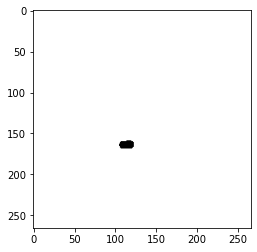

In [106]:
image_height = X.iloc[0,7]
image_width = X.iloc[0,8]
mask = rle_decode(image_segm1, image_height, image_width, 255)
# mask = (mask/255).astype(int).T
plt.imshow(mask, cmap='gray')

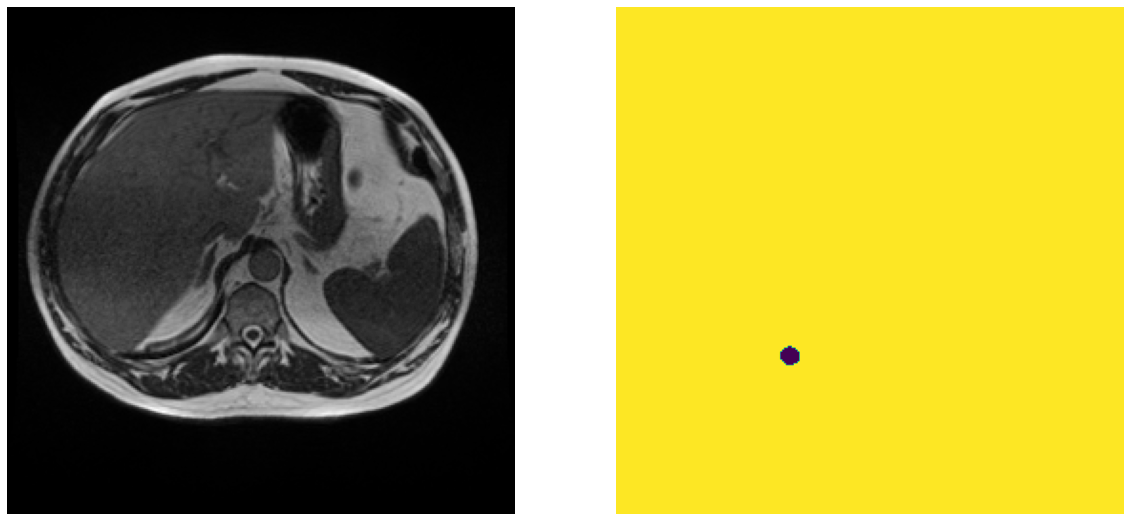

In [115]:
image_path1 = X.iloc[10,3]
image_segm1 = X.iloc[10,2]
image_height = X.iloc[10,7]
image_width = X.iloc[10,8]

image1 = np.array(Img.open(image_path1))


mask = rle_decode(image_segm1, image_height, image_width, 255)
# mask = (mask / 255).astype(int).T

fig, axes = plt.subplots(1,2,figsize=(20,15))
axes[0].axis('off')
axes[0].imshow(image1, cmap='gray')
axes[1].axis('off')
axes[1].imshow(mask)

plt.show()


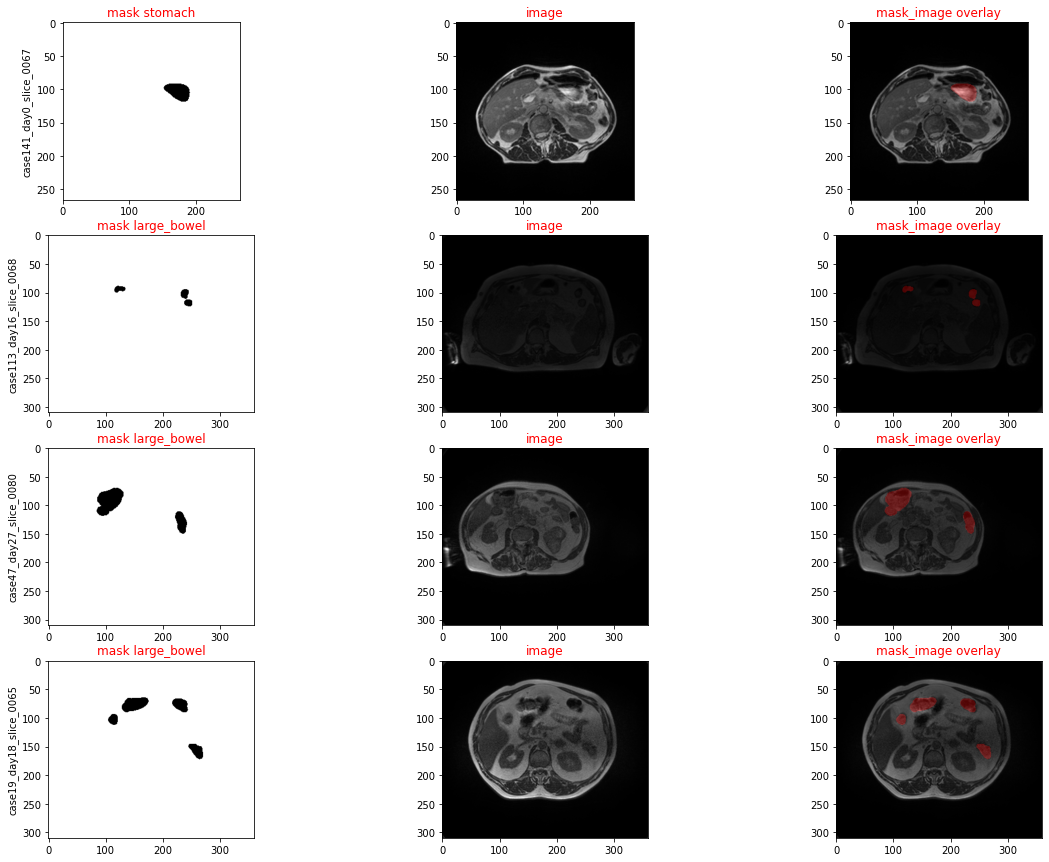

In [126]:
X = df_train[df_train['segmentation'].notnull()]

num_cols, num_rows = 3, 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20,15))

for i in range(num_rows):
    sample = X.iloc[random.randint(0, X.shape[0])]

    height, width = 255, 255
    mask = rle_decode(sample['segmentation'], sample['height'], sample['width'], 255)
    mask = (mask ).astype(int).T

  
    axes[i,0].set_title("mask "+sample['class'], color='red')
    axes[i,0].set_ylabel(sample['id'])
    axes[i,0].imshow(mask,cmap='gray')

    image = Img.open(sample['full_path'])
    axes[i,1].set_title("image", color='red')
    axes[i,1].imshow(np.array(image),cmap='gray')

    result_image = color.label2rgb(mask, np.array(image)/np.array(image).max())
    axes[i,2].set_title("mask_image overlay", color='red')
    axes[i,2].imshow(result_image)
